# Segunda Práctica Parte 2

Alejandro Jesús González Santana y Joaquín Ibáñez Peñalva

## Importación de librerías

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from functions_metrics import PSNR, SSIM, mae

## Definición de red neuronal

In [8]:


class SuperResolutionAutoencoder(nn.Module):
    def __init__(self):
        super(SuperResolutionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = F.interpolate(decoded, size=(28, 28), mode='bilinear', align_corners=False)

        return decoded

## Entrenamiento de la red

In [9]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid, batch_size=64, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SuperResolutionAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(data_loader):
        lr_images = F.interpolate(images, size=(14, 14), mode='area').to(device)
        hr_images = images.to(device)
        
        optimizer.zero_grad()
        outputs = model(lr_images)
        loss = criterion(outputs, hr_images)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')

Epoch:1, Loss:0.0415
Epoch:2, Loss:0.0280
Epoch:3, Loss:0.0242
Epoch:4, Loss:0.0242
Epoch:5, Loss:0.0168
Epoch:6, Loss:0.0189
Epoch:7, Loss:0.0163
Epoch:8, Loss:0.0182
Epoch:9, Loss:0.0186
Epoch:10, Loss:0.0127


## Evalución de la red con nuevos datos

In [10]:
model.eval()
total_mse = 0
num_samples = 0
for (img, labels) in data_loader_valid:
    img = img.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        reduced_img = F.interpolate(img, size=(14, 14), mode='area')
        recon = model(reduced_img)
        recon = F.interpolate(recon, size=(28, 28), mode='bicubic', align_corners=False)
        mse = criterion(recon, img)
        total_mse += mse.item() * img.size(0)
        num_samples += img.size(0)
        
        psnr_value = PSNR(recon, img)
        recon_np = recon.cpu().numpy()
        img_np = img.cpu().numpy()
        mae_value = mae(recon, img)

        print(f'PSNR: {psnr_value:.4f}, MAE: {mae_value:.4f}')

average_mse = total_mse / num_samples


print(f'Average MSE: {average_mse:.4f}')

PSNR: 66.7366, MAE: 0.0378
PSNR: 66.9322, MAE: 0.0366
PSNR: 66.6382, MAE: 0.0379
PSNR: 66.3574, MAE: 0.0387
PSNR: 66.8031, MAE: 0.0377
PSNR: 66.4327, MAE: 0.0391
PSNR: 66.8033, MAE: 0.0369
PSNR: 66.1383, MAE: 0.0417
PSNR: 66.4761, MAE: 0.0390
PSNR: 66.6602, MAE: 0.0388
PSNR: 66.1939, MAE: 0.0416
PSNR: 66.2500, MAE: 0.0402
PSNR: 66.3598, MAE: 0.0406
PSNR: 66.6145, MAE: 0.0386
PSNR: 66.3571, MAE: 0.0397
PSNR: 66.3072, MAE: 0.0405
PSNR: 66.0544, MAE: 0.0419
PSNR: 66.3623, MAE: 0.0397
PSNR: 66.6151, MAE: 0.0379
PSNR: 66.7564, MAE: 0.0375
PSNR: 65.7765, MAE: 0.0424
PSNR: 66.5685, MAE: 0.0391
PSNR: 66.4173, MAE: 0.0395
PSNR: 66.3901, MAE: 0.0399
PSNR: 66.7924, MAE: 0.0376
PSNR: 66.1776, MAE: 0.0411
PSNR: 66.7005, MAE: 0.0383
PSNR: 66.6383, MAE: 0.0384
PSNR: 66.5737, MAE: 0.0381
PSNR: 66.1685, MAE: 0.0413
PSNR: 66.4353, MAE: 0.0395
PSNR: 66.4031, MAE: 0.0394
PSNR: 66.5203, MAE: 0.0388
PSNR: 66.3382, MAE: 0.0411
PSNR: 66.6428, MAE: 0.0389
PSNR: 66.4597, MAE: 0.0395
PSNR: 66.0861, MAE: 0.0406
P

## Medidas para un conjunto de datos

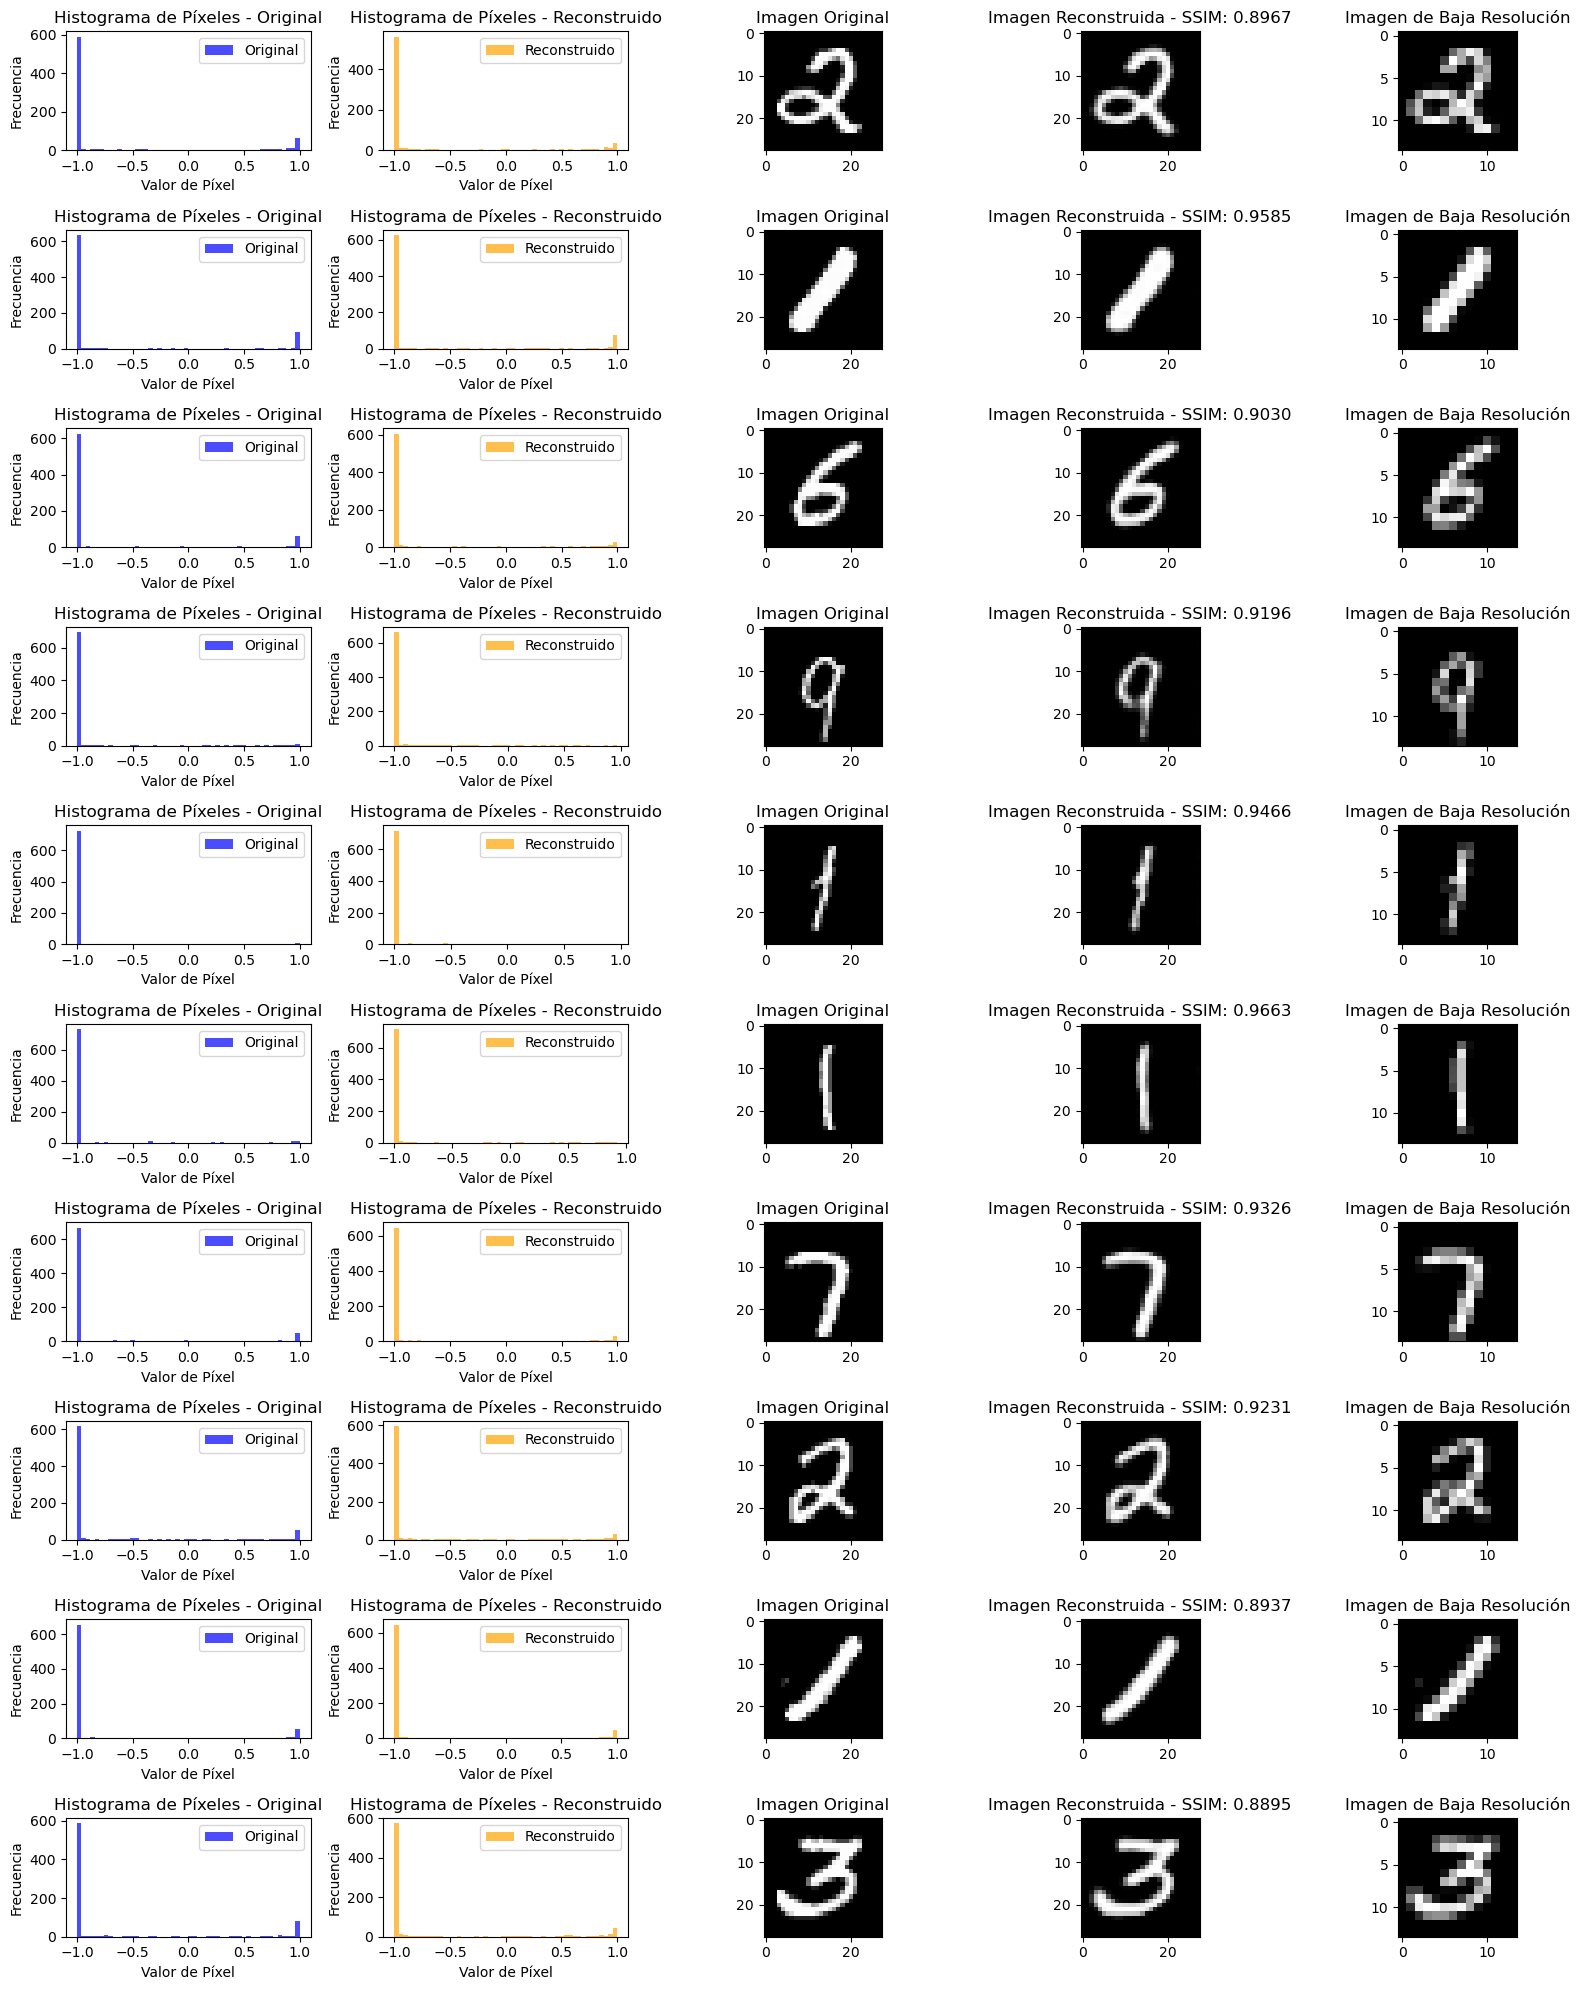

In [11]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np

model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)
images = images.to(device)

with torch.no_grad():
    reduced_img = F.interpolate(images, size=(14, 14), mode='area')
    reconstructions = model(reduced_img)

images_np = images.cpu().numpy()
reduced_images_np = reduced_img.cpu().numpy()
reconstructions_fixed = F.interpolate(reconstructions, size=(28, 28), mode='bicubic', align_corners=False)
reconstructions_fixed_np = reconstructions_fixed.cpu().numpy()
reconstructions_np = reconstructions.cpu().numpy()


num_images = 10

fig, axes = plt.subplots(num_images, 5, figsize=(16, 2*num_images))

for i in range(num_images):
    original_gray = images_np[i].reshape(28, 28)
    reconstructed_gray = reconstructions_fixed_np[i].reshape(28, 28)
    reduced_img_gray = reduced_images_np[i].reshape(14, 14)
    ssim_index = SSIM(original_gray, reconstructed_gray)

    axes[i, 0].hist(original_gray.flatten(), bins=50, color='blue', alpha=0.7, label='Original')
    axes[i, 0].set_title('Histograma de Píxeles - Original')
    axes[i, 0].set_xlabel('Valor de Píxel')
    axes[i, 0].set_ylabel('Frecuencia')
    axes[i, 0].legend()

    axes[i, 1].hist(reconstructed_gray.flatten(), bins=50, color='orange', alpha=0.7, label='Reconstruido')
    axes[i, 1].set_title('Histograma de Píxeles - Reconstruido')
    axes[i, 1].set_xlabel('Valor de Píxel')
    axes[i, 1].set_ylabel('Frecuencia')
    axes[i, 1].legend()

    axes[i, 2].imshow(original_gray, cmap='gray')
    axes[i, 2].set_title('Imagen Original')

    axes[i, 3].imshow(reconstructed_gray, cmap='gray')
    axes[i, 3].set_title(f'Imagen Reconstruida - SSIM: {ssim_index:.4f}')

    axes[i, 4].imshow(reduced_img_gray, cmap='gray')
    axes[i, 4].set_title('Imagen de Baja Resolución')


plt.tight_layout()
plt.show()